# Assignment 3
## Daniel Tan (22684196)

This assignment covers concepts covering PCA, K-means clustering, and Hierarchical Clustering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threadpoolctl

## Part I: Breast Cancer Dataset

In the previous assignments, we looked at the breast cancer dataset, where we attempted to identify whether a tumour is malignant or benign - to then be able to treat it correctly. We understood that accuracy was probably not a accurate representation of any classification model, as we would want to make sure that we treated positive cases and not negative cases, likewise, and more importantly, catching all the positive cases. Therefore, precision and recall were better suited metrics to assess the binary classification model.

In this assignment, we revisit this dataset, with the same goals in mind. A logistic regression and decision tree model will be fitted to predict the tumour status. Additionally, we aim to also find the importance of cell nucleus features, and we can do this using Principal Component Analysis (PCA).

**Loading in the Dataset**

In [2]:
breast_cancer = pd.read_csv('../datasets/breast-cancer.csv', sep=',')

In [3]:
# Quick look at the dataframe
breast_cancer.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


A glance at the dataframe shows us the diagnosis (prediction variable) and the other 10 features. Additionally, we can remove the id column, as it is not useful in our model. Likewise, it is good practice to inspect any anomaly or invalid cases in the data before modelling.

In [4]:
# drop the id column
breast_cancer = breast_cancer.drop('id', axis=1)

In [5]:
# Check for any missing values in the dataset
null_count = np.array(breast_cancer.isnull().sum())
na_counts = np.array(breast_cancer.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=breast_cancer.columns, index=['null_count','na_counts'])

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
null_count,0,0,0,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0,0,0,0


In [6]:
breast_cancer.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


We can tell that the data looks quite okay. However, we can see that a particular feature (area_mean) has much higher values compared to the other features, and variance is much larger as well. 

No null or invalid values, which is good.

With all machine learning algorithms, we first need to seperate the dataset into training and test sets. We use a 85/15 split.

In [7]:
from sklearn.model_selection import train_test_split

X = breast_cancer.iloc[:,1:11]
y = breast_cancer.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5508)

In [8]:
# Inspect the dimensions of the training and test sets, for both y and x 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((483, 10), (483,), (86, 10), (86,))

In this section, we will be exploring the dataset, and fitting a logistic regression model and a decision tree model to predict the diagnosis of a tumour. Additionally, we will be using PCA to find the most important features in the dataset.

Therefore, we need to scale the data prior to model fitting when doing PCA. Do note that for a logistic regression model, scaling is not necessary, as the coefficients will be scaled accordingly. However, for a decision tree model, scaling is necessary, as the tree will be built based on the scaled values. We can then use the StandardScaler() function to scale the data.

In [9]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# turn it back into dataframe
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

**1a. Logistic Regression**

In this section, we build a logistic regression model on the training set to predict tumour status. Additionally, we want to find the optimal hyperparameters that we achieve the best model. We first start of with the base model with no hyperparameters.

In [10]:
from sklearn.linear_model import LogisticRegression

bc_logreg_base = LogisticRegression(random_state=5508, max_iter=10000)
bc_logreg_base.fit(X_train.values, y_train)

LogisticRegression(max_iter=10000, random_state=5508)

In [11]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

# Start by evaluating the model on the training set
y_train_pred = bc_logreg_base.predict(X_train.values)
y_test_pred = bc_logreg_base.predict(X_test.values)
target_names = bc_logreg_base.classes_

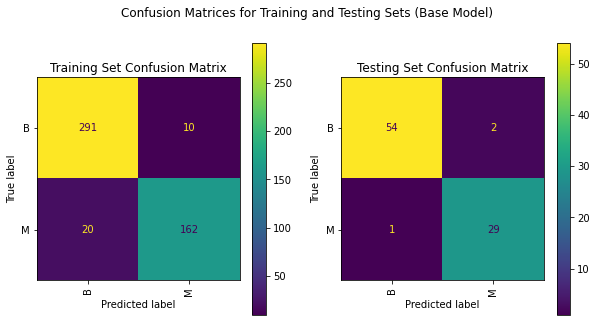

In [12]:
# Function to display the confusion matrix for the training and testing sets
def display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, model_name):
    test_cm = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=target_names)
    train_cm = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=target_names)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Training Set Confusion Matrix')
    disp_train.plot(ax=axs[0], xticks_rotation='vertical')
    axs[1].set_title('Testing Set Confusion Matrix')
    disp_test.plot(ax=axs[1], xticks_rotation='vertical')
    fig.suptitle(f'Confusion Matrices for Training and Testing Sets ({model_name})')
    plt.show()
    
# Base Model Confusion Matrix for 2 class benign/malignant classification
display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, 'Base Model')

In [13]:
# Classification report
def summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names):
    print('Training Set Report:')
    print(classification_report(y_train, y_train_pred, target_names=target_names))
    print('Testing Set Report:')
    print(classification_report(y_test, y_test_pred, target_names=target_names))

summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names)

Training Set Report:
              precision    recall  f1-score   support

           B       0.94      0.97      0.95       301
           M       0.94      0.89      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.93      0.93       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.96      0.97        56
           M       0.94      0.97      0.95        30

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



From the above model predictions and performance metrics, we can see that our base model might not be the best at catching the malignant tumors. The recall parameter tells us the number of classified positive cases as a proportion of true positive cases. This metric is important for both catching the malignant tumors accurately. The precision parameter is more important to catching the benign tumors as we do not want to misclassify them and treat them using malignant treatments.

We continue to find the best model using hyperparameter tuning and then cross-validation.

In [14]:
# Hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

# grid of hyperparameters to search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear','saga'],
                'class_weight': ['balanced', None],
}

bc_logreg_cv = GridSearchCV(bc_logreg_base, param_grid, cv=5, scoring = make_scorer(recall_score, pos_label='M'), n_jobs=-1)
# Fit to the training data
bc_logreg_cv.fit(X_train.values, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=5508),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score, pos_label=M))

Upon using the Grid Search CV, we can look at the best hyperparameters that gives us the best recall score on Malignant instances.

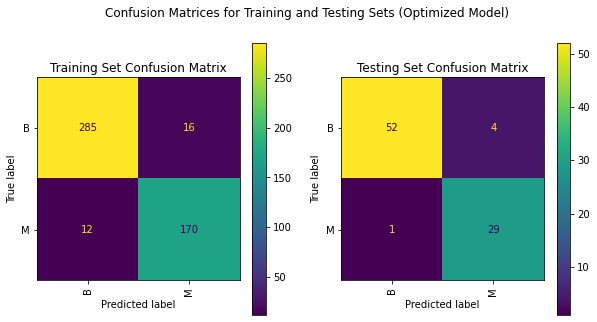

Training Set Report:
              precision    recall  f1-score   support

           B       0.96      0.95      0.95       301
           M       0.91      0.93      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.93      0.95        56
           M       0.88      0.97      0.92        30

    accuracy                           0.94        86
   macro avg       0.93      0.95      0.94        86
weighted avg       0.95      0.94      0.94        86



In [15]:
# Best model
bc_logreg_best = bc_logreg_cv.best_estimator_
bc_logreg_best.fit(X_train.values, y_train)

y_train_best = bc_logreg_best.predict(X_train.values)
y_test_best = bc_logreg_best.predict(X_test.values)

display_confusion_matrix(y_train, y_test, y_train_best, y_test_best, target_names, 'Optimized Model')
summarize_classification(y_train, y_test, y_train_best, y_test_best, target_names)

The recall scores on the malignant observations have increased for the training set, but remains the same for the test set at 0.97. We favour the recall score over the precision score for the malignant as a trade off as we want to make sure that we catch all the malignant tumors. The precision score is as we can see increased for the begnin tumors, which is good as we do not want to misclassify them as malignant and treat them using malignant treatments.

Therfore, this is exactly what we were after. However, to acertain that our new logistic regression model with the optimal hyperparameters is much better than the base model, we can use k-fold cross validation using k=5. 

In [16]:
# Cross Validation, prepare the scorers on each class
scorers = {
    'precision': make_scorer(precision_score, pos_label='B'),
    'recall': make_scorer(recall_score, pos_label='M')
}

def cross_validation(model, X_train, y_train, cv=5):
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scorers)
    return cv_scores
    
cv_scores_base = cross_validation(bc_logreg_base, X_train, y_train, cv=5)
cv_scores_best = cross_validation(bc_logreg_best, X_train, y_train, cv=5)

In [17]:
print(f"Base Model Precision: {cv_scores_base['test_precision'].mean()}, Recall: {cv_scores_base['test_recall'].mean()}")
print(f"Optimal Model Precision: {cv_scores_best['test_precision'].mean()}, Recall: {cv_scores_best['test_recall'].mean()}")

Base Model Precision: 0.9335364051153526, Recall: 0.884984984984985
Optimal Model Precision: 0.9504965353519301, Recall: 0.9177177177177176


The recommended choice, given a choice between the 2 logistic regression models for identifying a benign or malignant tumor classification problem would have to be the latter **optimal model**.

In [18]:
# Optimal Hyperparameters for the LR model using GridSearchCV
bc_logreg_cv.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

**1b. Decision Tree Classifier**

In the second part of the classification prediction, we would like to achieve the same goals, but this time using a decision tree classsifier.
Similarly, we start with the base model and then work our way up to find the optimal decision tree.

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Base model
bc_tree_base = DecisionTreeClassifier(random_state=5508)
bc_tree_base.fit(X_train.values, y_train)
bc_tree_base_train_pred = bc_tree_base.predict(X_train.values)
bc_tree_base_pred = bc_tree_base.predict(X_test.values)

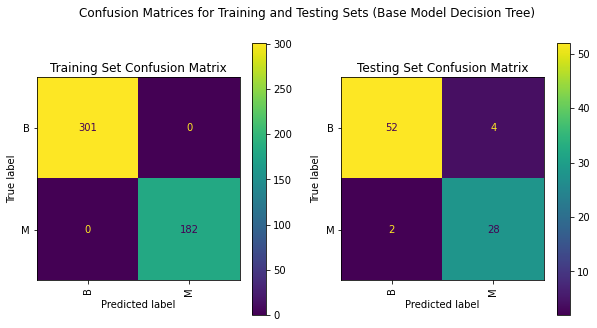

Training Set Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00       301
           M       1.00      1.00      1.00       182

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.96      0.93      0.95        56
           M       0.88      0.93      0.90        30

    accuracy                           0.93        86
   macro avg       0.92      0.93      0.92        86
weighted avg       0.93      0.93      0.93        86



In [20]:
display_confusion_matrix(y_train, y_test, bc_tree_base_train_pred, bc_tree_base_pred, target_names,'Base Model Decision Tree')
summarize_classification(y_train, y_test, bc_tree_base_train_pred, bc_tree_base_pred, target_names)

If we look at our model results from the metrics and confusion table above, we can observe that precision, recall and accuracy scores are perfect in the training set. However, this is not the case with the test set - which is a good indication that our decision tree model might be overfitted to the training data. 

Therefore, we might want to find a more generalised decision tree, which might be require pruning. Once again, we tune the hyperparameters and cross-validate it. 

In [21]:
# Hyperparameter tuning for decision tree using GridSearchCV
param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                'class_weight': ['balanced', None],}
bc_tree_cv = GridSearchCV(bc_tree_base, param_grid, scoring=make_scorer(recall_score, pos_label="M"), cv=5, n_jobs=-1)
bc_tree_cv.fit(X_train.values, y_train)
# a quick look at the best parameters
bc_tree_cv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [22]:
# Evaluate the model with the best parameters
bc_tree_best = bc_tree_cv.best_estimator_
bc_tree_best.fit(X_train.values, y_train)
bc_tree_best_train_pred = bc_tree_best.predict(X_train.values)
bc_tree_best_pred = bc_tree_best.predict(X_test.values)

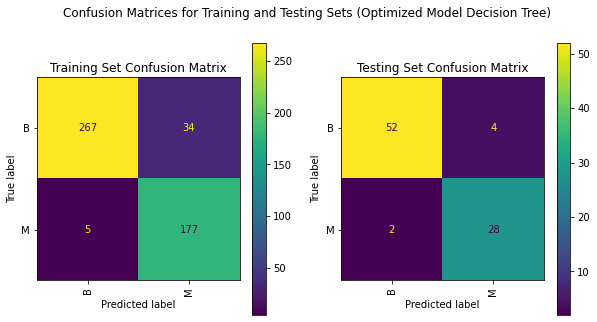

Training Set Report:
              precision    recall  f1-score   support

           B       0.98      0.89      0.93       301
           M       0.84      0.97      0.90       182

    accuracy                           0.92       483
   macro avg       0.91      0.93      0.92       483
weighted avg       0.93      0.92      0.92       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.96      0.93      0.95        56
           M       0.88      0.93      0.90        30

    accuracy                           0.93        86
   macro avg       0.92      0.93      0.92        86
weighted avg       0.93      0.93      0.93        86



In [23]:
# Confusion matrix and classification report
display_confusion_matrix(y_train, y_test, bc_tree_best_train_pred, bc_tree_best_pred, target_names, 'Optimized Model Decision Tree')
summarize_classification(y_train, y_test, bc_tree_best_train_pred, bc_tree_best_pred, target_names)

From the model above, we can see that the model has generalised well to the test set, as the recall scores are much the same than the base model. Despite the precision score being lower, we are more interested in the recall score, as we want to make sure that we catch all the malignant tumors. Therefore, we can conclude that the optimal decision tree model is better than the base model, in terms of it not overfitting to the training data and generalising well to the test set, and also retaining a good recall score. 

The hyperparameters selected for the optimal decision tree model are as follows:
- 'class_weight': 'balanced'
- 'criterion': 'entropy'
- 'max_depth': 2
- 'min_samples_leaf': 1
- 'min_samples_split': 2

In [24]:
# Perform Cross validation between the base and optimal decsiion tree models
cv_scores_base = cross_validation(bc_tree_base, X_train, y_train, cv=5)
cv_scores_best = cross_validation(bc_tree_best, X_train, y_train, cv=5)

print(f"Base Model Precision: {cv_scores_base['test_precision'].mean()}, Recall: {cv_scores_base['test_recall'].mean()}")
print(f"Optimal Model Precision: {cv_scores_best['test_precision'].mean()}, Recall: {cv_scores_best['test_recall'].mean()}")

Base Model Precision: 0.9370517472826048, Recall: 0.895045045045045
Optimal Model Precision: 0.975169725078981, Recall: 0.9615615615615616


We see here that the precision on benign has increased, and recall on malignant has increased as well for the optimal model. Therefore, the optimal decison tree model is better than the base model and we pick that.

**2. Feature Importance**

After looking at the two models that we have fit earlier, as well as the optimal models being trained, we want to look at the features that perhaps contribute the most to the prediction of the tumour status. For the logistic regression, we can take a look at the coefficients of the model, and for the decision tree, we can look at which feature is being used as the largest information gain.

In [25]:
# Logistic Regression Coefficients
# Get the coefficients from the logistic regression model
logreg_coef = pd.DataFrame(bc_logreg_best.coef_, columns=X_train.columns, index=['Coefficients']).T
# Sort the values by the absolute value of the coefficients
logreg_coef['abs'] = logreg_coef['Coefficients'].abs()
logreg_coef.sort_values(by='abs', ascending=False, inplace=True)
logreg_coef.drop(columns='abs', inplace=True)
logreg_coef

,Coefficients
area_mean,3.103620
concave points_mean,2.029002
texture_mean,1.384317
smoothness_mean,0.783628
concavity_mean,0.589369
fractal_dimension_mean,-0.348289
symmetry_mean,0.260186
radius_mean,0.000000
perimeter_mean,0.000000
compactness_mean,0.000000


From the table of coeffecients above, we can see that top 3 the most important features that allow us to identify a malignant tumor for the LR model are:
- area_mean
- concave_points_mean
- texture_mean

In [26]:
# Decision Tree Feature Importance
# Get the feature importances from the decision tree model
tree_importance = pd.DataFrame(bc_tree_best.feature_importances_, columns=['Importance'], index=X_train.columns)
# Sort the values by the absolute value of the coefficients
tree_importance['abs'] = tree_importance['Importance'].abs()
tree_importance.sort_values(by='abs', ascending=False, inplace=True)
tree_importance.drop(columns='abs', inplace=True)
tree_importance

,Importance
concave points_mean,0.781365
area_mean,0.218635
radius_mean,0.000000
texture_mean,0.000000
perimeter_mean,0.000000
smoothness_mean,0.000000
compactness_mean,0.000000
concavity_mean,0.000000
symmetry_mean,0.000000
fractal_dimension_mean,0.000000


In the decision tree model, we can see that the top 3 most important features are:
- concave_points_mean
- area_mean
- NA

Here, we see that only concave_points_mean and area_mean contribute all of the feature importance to the decision tree model. These 2 features are also found in the top 3 most important features for the logistic regression model, but the LR model has area_mean having a higher chance of impacting the prediction of a tumor status. Therefore, we can conclude that these 2 features are the most important features in predicting the tumour status.

**3. Principal Component Analysis Feature Selection**

Here, we aim to perform feature selection using PCA, which will allow us to find which features are the most important in predicting the tumour status. We would like to choose the number of dimensions that explain at least 95% of the variance in the dataset.

In [27]:
# PCA Analysis
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=0.95)
PCA_model.fit(X_train)
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)


In [28]:
PCA_model.n_components_

5

In [29]:
# get names of pca model, in accordance with the number of components
PCA_names = []
for i in range(1, PCA_model.n_components_ + 1):
    PCA_names.append(f'PC{i}')

In [30]:
X_train_PCA = pd.DataFrame(X_train_PCA, columns=PCA_names)
X_test_PCA = pd.DataFrame(X_test_PCA, columns=PCA_names)

# Attach the target variable to the PCA results
X_train_PCA['diagnosis'] = y_train.reset_index(drop=True)
X_test_PCA['diagnosis'] = y_test.reset_index(drop=True)

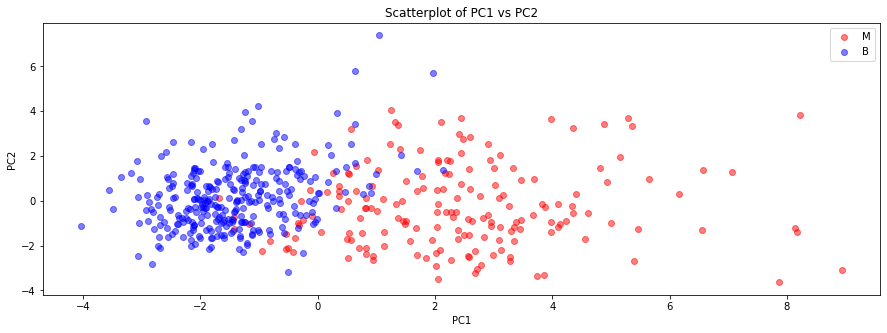

In [31]:
# Create a color map for diagnosis
color_map = {'M': 'red', 'B': 'blue'}
plt.figure(figsize=(15, 5))

for type in ['M', 'B']:
    is_diagnosis = X_train_PCA['diagnosis'] == type
    plt.scatter(X_train_PCA.loc[is_diagnosis, 'PC1'], X_train_PCA.loc[is_diagnosis, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of PC1 vs PC2')
plt.legend()  # Automatically uses labels specified in plt.scatter
plt.show()


From the scatterplot of PC1 and PC2 above, we can see that there is a clear separation between the benign and malignant tumors. We see that PC1 explains the variance greatly as the benign tumours take on lower PC1 scores, and the malignant ones have higher PC1 scores. If we look at the points along the PC2 axis, they do not show any seperation. Therefore, we can perhaps conclude the PC1 contains the most amount of variance. The variance ratio shows us that PC1 explains 54% of the variance, and PC2 explains 25% of the variance as expected given the scatterplot above. 

In [32]:
# Get the explained variance ratio from the PCA model
variance_ratio = pd.DataFrame(PCA_model.explained_variance_ratio_, columns=['Explained Variance Ratio'], index=PCA_names)
variance_ratio

,Explained Variance Ratio
PC1,0.538165
PC2,0.253507
PC3,0.088867
PC4,0.053371
PC5,0.038925


**4. PC1 and PC2 Biplots/ 5. Biplot Interpretation**

From the PCA model, we have shown that the first 2 principal components explain 79% of the variance in the dataset. Therefore, we can plot a biplot of PC1 and PC2 to see which features are the most important in predicting the tumour status.

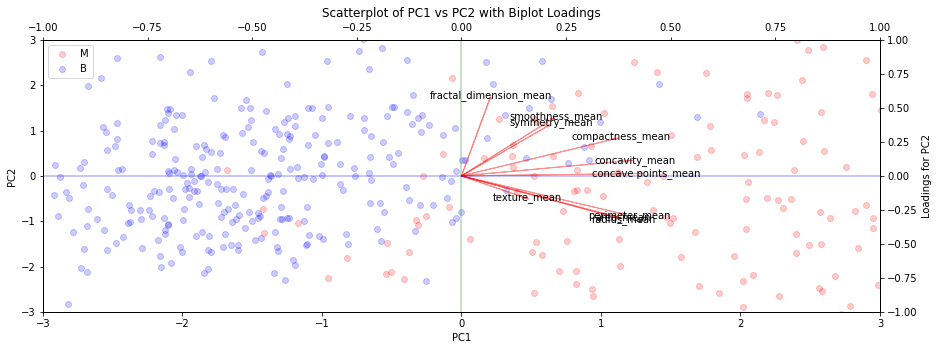

In [33]:
# Scatterplot of PC1 vs PC2 with biplot

fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in ['M', 'B']:
    is_diagnosis = X_train_PCA['diagnosis'] == type
    ax1.scatter(X_train_PCA.loc[is_diagnosis, 'PC1'], X_train_PCA.loc[is_diagnosis, 'PC2'], 
                color=color_map[type], alpha=0.2, label=type)

loadings = pd.DataFrame(PCA_model.components_.T, columns=PCA_names, index=X_train.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

# change figure limits
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings')
ax1.legend()
plt.show()

Looking at the scatterplot together with the biplot, we see that PC1 tackles the most variance in the dataset. We also observe that all of the variables are positively correlated to PC1, of varying degrees, where the vectors all point towards the positive side of the PC1 axis, and towards more of the malignant tumors. We can see that the features that contribute the most to PC1 are: Concave points mean, concavity mean and perimeter mean. For PC2, the features that contribute the most are: fractal dimension mean, smoothness mean and symmetry mean.

To see which features are more related to tumour status, we can see that perimeter mean, area mean and radius mean are the most important features in predicting the tumour status. However, seeing that they are so closely correlated to each other, keeping one of them would be sufficient. Smoothness mean and compactness mean might also be important in predicting tumor status.

Overall, we see that for all features, a higher value of the feature would mean that the tumor is more likely to be malignant. Where more of the malignant tumors are found on the positive side of the PC1 axis, and more of the benign tumors are found on the negative side of the PC1 axis, and higher scores on features like concave points and primeter mean are more likely to be malignant.

To complete our understanding of how each variable contributes to PC1 and PC2, we can look at the feature strengths in model components.

In [34]:
# PC1 vs PC2 feature strength
feature_strength = pd.DataFrame(PCA_model.components_.T, columns=PCA_names, index=X_train.columns)
feature_strength['abs_PC1'] = feature_strength['PC1'].abs()
feature_strength['abs_PC2'] = feature_strength['PC2'].abs()
feature_strength.sort_values(by='abs_PC1', ascending=False, inplace=True)
feature_strength.drop(columns=['abs_PC1', 'abs_PC2'], inplace=True)
feature_strength

,PC1,PC2,PC3,PC4,PC5
concave points_mean,0.420834,0.017094,-0.066982,-0.070246,-0.014636
concavity_mean,0.395966,0.110982,0.054832,-0.188123,0.299313
perimeter_mean,0.381388,-0.276714,-0.119289,0.020237,-0.008159
radius_mean,0.369345,-0.305992,-0.130974,0.037852,-0.033071
area_mean,0.368316,-0.298970,-0.128965,0.020003,-0.025937
compactness_mean,0.364129,0.270729,0.066935,-0.189521,0.235315
smoothness_mean,0.215740,0.416131,-0.186609,-0.069539,-0.841014
symmetry_mean,0.205064,0.364969,0.064668,0.890708,0.145729
texture_mean,0.151007,-0.159990,0.941193,0.000966,-0.253288
fractal_dimension_mean,0.067771,0.567933,0.123130,-0.351165,0.245550


**6. Use the 5 Principal Components as Features in Logistic Regression**

Given that we have found the 5 principal components that explain at least 95% variance in the dataset, we can use these 5 principal components as features in a logistic regression model.

In [35]:
# Building a Logistic Regression Model with PCA, starting with the base model
# Call the X_train and X_test again
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)
X_train_PCA = pd.DataFrame(X_train_PCA, columns=PCA_names)
X_test_PCA = pd.DataFrame(X_test_PCA, columns=PCA_names)

# Create the base logistic regression model
lr_pca_base = LogisticRegression(random_state=5508)
lr_pca_base.fit(X_train_PCA, y_train)

# Get predictions for the training and test set
y_train_pred = lr_pca_base.predict(X_train_PCA)
y_test_pred = lr_pca_base.predict(X_test_PCA)
target_names = lr_pca_base.classes_

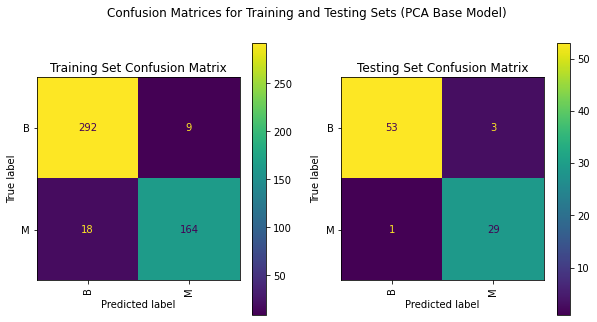

------------------- Model Summary (PCA Base Model) ----------------------
Training Set Report:
              precision    recall  f1-score   support

           B       0.94      0.97      0.96       301
           M       0.95      0.90      0.92       182

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        56
           M       0.91      0.97      0.94        30

    accuracy                           0.95        86
   macro avg       0.94      0.96      0.95        86
weighted avg       0.96      0.95      0.95        86



In [36]:
# Model Evaluation using Confusion Matrix and Classification Report
display_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, target_names, 'PCA Base Model')
print("------------------- Model Summary (PCA Base Model) ----------------------")
summarize_classification(y_train, y_test, y_train_pred, y_test_pred, target_names)

In [37]:
# Likewise, we try to find the optimal hyperparameters to give us the best model with recall on Maligant.

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga'],
                'class_weight': ['balanced', None],
}

lr_optim_pca_cv = GridSearchCV(bc_logreg_base, param_grid, cv=5, scoring = make_scorer(recall_score, pos_label='M'), n_jobs=-1)
lr_optim_pca_cv.fit(X_train_PCA.values, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=5508),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score, pos_label=M))

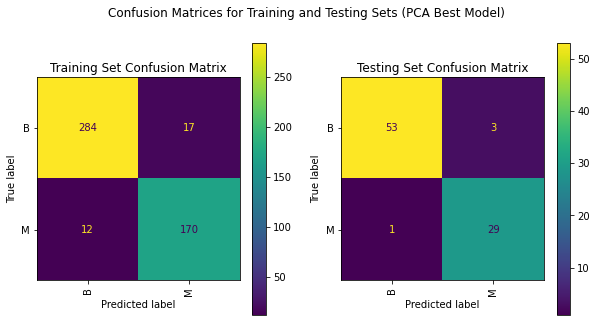

------------------- Model Summary (PCA Best Model) ----------------------
Training Set Report:
              precision    recall  f1-score   support

           B       0.96      0.94      0.95       301
           M       0.91      0.93      0.92       182

    accuracy                           0.94       483
   macro avg       0.93      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483

Testing Set Report:
              precision    recall  f1-score   support

           B       0.98      0.95      0.96        56
           M       0.91      0.97      0.94        30

    accuracy                           0.95        86
   macro avg       0.94      0.96      0.95        86
weighted avg       0.96      0.95      0.95        86



In [38]:
# Best model for PCA
lr_optim_pca = lr_optim_pca_cv.best_estimator_
lr_optim_pca.fit(X_train_PCA, y_train)

# Get predictions for the training and test set
y_train_best = lr_optim_pca.predict(X_train_PCA)
y_test_best = lr_optim_pca.predict(X_test_PCA)

display_confusion_matrix(y_train, y_test, y_train_best, y_test_best, target_names, 'PCA Best Model')
print("------------------- Model Summary (PCA Best Model) ----------------------")
summarize_classification(y_train, y_test, y_train_best, y_test_best, target_names)

In [39]:
# Look at the best parameters 
lr_optim_pca_cv.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

If we compare the results on the base model and the optimal model we can observe that there is an increase in recall scores for the malignant tumors. This is apparent in the training set, but in the test set, it remains the same. We pick the optimal model as it is better at catching the malignant tumors correctly without sacrificing generalisation to the test set.

Comparing the optimal model by using the 5 PCs and the regular scaled data, we can observe that there is not any significant different between the 2 results. In fact, the PCA model might have done slightly better in the test set. Reducing the feature dimension down to the 5 principal components might have helped the model to generalise better to the test set. Therefore, PCA might be a good option to use before fitting a logistic regression model.

## Part II: Airline Safety Records

In this section of the assignment, we analyse the airline safety dataset. The premise of the dataset is about people's reactions to high profile airline accidents - and why they would avoid travelling with certain particular airlines. Hence, we will use the dataset to investigate which airlines are similar based on their past safety records.

The main modelling that we will do here is using K-means clustering. Given that the dataset does not have a target variable, this is an unsupervised learning problem. We will use the K-means algorithm to cluster the airlines based on their safety records. We will then use the clusters to identify which airlines are similar to each other.

**Loading in the Dataset**

In [67]:
# Load the data
airline = pd.read_csv('../datasets/airline-safety.csv')
airline.head(5)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


The description of the features in the airline data is:
- **airline** - the name of the airline (and regional subsidaries)
- **avail_seat_km_per_week** - the number of available seat kilometers flown by the airline per week
- **incidents_85_99** - the number of incidents that occured between 1985 and 1999
- **fatal_accidents_85_99** - the number of fatal accidents that occured between 1985 and 1999
- **fatalities_85_99** - the total number of fatalities that occured between 1985 and 1999
- **incidents_00_14** - the number of incidents that occured between 2000 and 2014
- **fatal_accidents_00_14** - the number of fatal accidents that occured between 2000 and 2014
- **fatalities_00_14** - the total number of fatalities that occured between 2000 and 2014

We can see that the data is somewhat broken down into 3 components:
- The name of the airline and the number of available seat kilometers flown by the airline per week
- The number of incidents, fatal accidents and fatalities that occured between 1985 and 1999
- The number of incidents, fatal accidents and fatalities that occured between 2000 and 2014

The variables in the second and third components are closely related to each other. For example, the number of incidents that occured between is related to the number of fatal accidents. Therefore, fatal accidents cannot be more than the number of incidents. We might consider just using one of the variables in each component to avoid redundancy. However, we will keep all the variables for now.

In [68]:
airline.head(10)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0
5,Air France,3004002661,14,4,79,6,2,337
6,Air India*,869253552,2,1,329,4,1,158
7,Air New Zealand*,710174817,3,0,0,5,1,7
8,Alaska Airlines*,965346773,5,0,0,5,1,88
9,Alitalia,698012498,7,2,50,4,0,0


Before we analyse the data, we will load in the dataset and do some basic data cleaning. It is good practice once again to check if there are any missing or invalid data in the dataset. 

More importantly, as we have looked at the dataset, we can see that the variable avail_seat_km_per_week is a extremely large in comparison to the other variables. We can either use a different metric to scale down the variable, or perform scaling on the dataset.

In [69]:
# Check for missing values
null_count = np.array(airline.isnull().sum())
na_counts = np.array(airline.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=airline.columns, index=['null_count','na_counts'])

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
null_count,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0


Before we perform scaling, there is an important aspect in the data that relates to the feature avail_seat_km_per_week. The feature is a measure of the size of the airline, and obviouly airlines that are bigger will fly more and hence have more incidents. Therefore, we will scale the feature space by the size of the airline and get a meaure of for example incidents per week per km. This will allow us to compare airlines of different sizes on a similar scale.

In [70]:
# Before scaling the data, we need to remove the 'airline' column and store it first
airline_name = airline['airline']
airline_v = airline.drop('airline', axis=1)

# feature space turned into per km
airline_v = airline_v.div(airline_v['avail_seat_km_per_week'], axis=0)
airline_v = airline_v.drop('avail_seat_km_per_week', axis=1)

# Scaling the data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
airline_scaled = pd.DataFrame(scaler.fit_transform(airline_v), columns=airline_v.columns)

In [71]:
airline_scaled.head(5)

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.152448,-0.779887,-0.681982,-0.886780,-0.557278,-0.390682
1,5.032801,3.113161,-0.120121,0.191619,0.000220,0.052399
2,0.692030,-0.779887,-0.681982,-0.328824,-0.557278,-0.390682
3,-0.261740,-0.221907,-0.118272,0.916466,-0.557278,-0.390682
4,-0.620021,-0.779887,-0.681982,-0.655968,-0.557278,-0.390682


### K-Means Clustering

We want to figure out what is the optimal number of clusters, where optimal in a sense being that the within cluster distances (meausured by Euclidan distances) are minimised. We can determine the k-number of clusters by using a elbow/scree plot. Alternatively, we can also use the silhouette score to determine the optimal number of clusters.

The silhouette score calculates the mean siluhouette coefficient of all samples. 

**1. Finding the optimal number of clusters using k**

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# We want to find the best k value for kmeans:
# First we define the range of the k values to test:
k_values = np.arange(2, 11)
scores = []
inertia = []
print('Silhouette Scores for k = 2 to 10:')
for i in k_values:
    kmeans = KMeans(n_clusters=i, random_state=5508, n_init=10)
    kmeans.fit_predict(airline_scaled.values)
    score = silhouette_score(airline_scaled.values, kmeans.labels_)
    scores.append(score)
    inertia.append(kmeans.inertia_)
    print('k = {}, Average Score: {}'.format(i, score))

Silhouette Scores for k = 2 to 10:
k = 2, Average Score: 0.5494544011830644
k = 3, Average Score: 0.5555997936034959
k = 4, Average Score: 0.5444077992085773
k = 5, Average Score: 0.4923890068979615
k = 6, Average Score: 0.30429520880077765
k = 7, Average Score: 0.29979914246459677
k = 8, Average Score: 0.3169814411566127
k = 9, Average Score: 0.3405946165524244
k = 10, Average Score: 0.34608830580246597


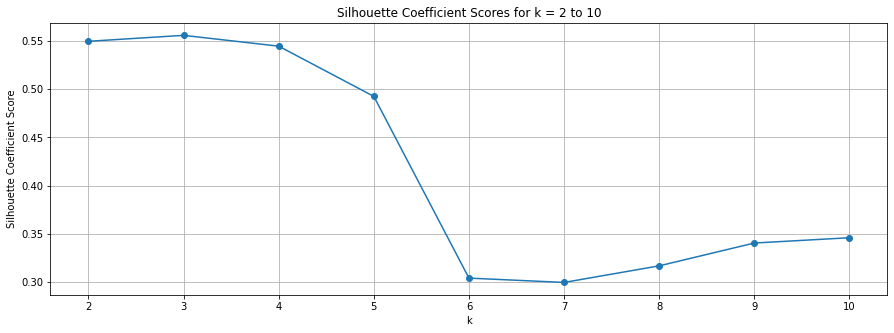

In [73]:
# Plot the silhouette coefficient socres for each k value
plt.figure(figsize=(15, 5))
plt.plot(k_values, scores, marker='o')
plt.title('Silhouette Coefficient Scores for k = 2 to 10')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient Score')
plt.grid()

Looking at the silhouette score, we can see that the optimal number of clusters is 3. We want to affirm our understanding of the number of k-clusters. Therefore, we might want to look at the elbow plot as well.

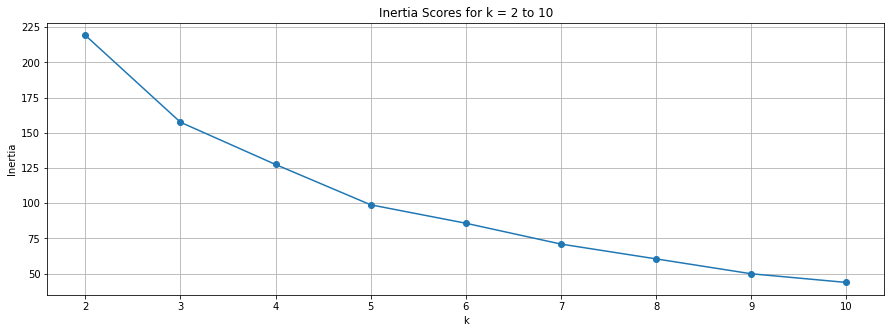

In [74]:
# Evaluate the best k value using the elbow method
plt.figure(figsize=(15, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Inertia Scores for k = 2 to 10')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid()

Unfortunately, the inertia elbow plot does not provide us much information about which k to choose as the optimal number of clusters. We can see that the inertia decreases as the number of clusters increases, which is to be expected. However, we also do not observe an "elbow" or an inflection point in the plot. Hence, we use the infomation from the silhouette score to determine the optimal number of clusters. 

**2. Using k=3 for K-Means Clustering**

In the part above, we chose k=3 to be the optimal number of clusters for our dataset. We want to run the k-Means clustering again and try to interpret the results of the clusters

In [75]:
k3 = KMeans(n_clusters=3, random_state=5508, n_init=10)
k3.fit_predict(airline_scaled.values)

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Given that we are in a 6-dimensional feature space, it might be difficult to visualise the clusters. One alternative is to use a pairwise scatter plot to visualise the clusters. However, we might be better able to understand and interpret the groups in terms of the features if we use a parallel coordinates plot. Another way is to just look at the values of the cluster centroids.

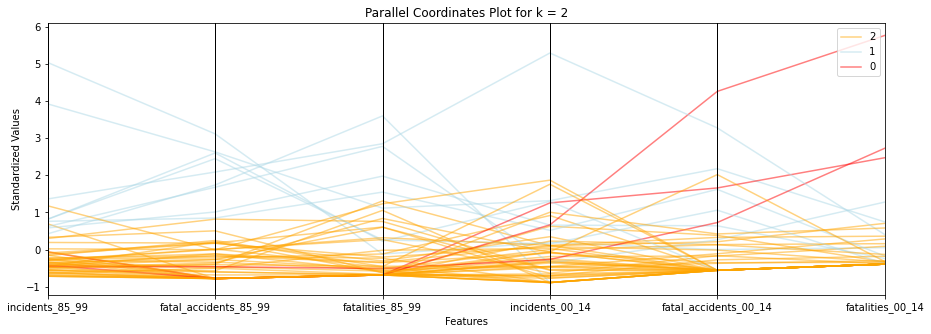

In [76]:
# Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates
features = airline_scaled.columns
airline_scaled['cluster'] = k3.labels_

plt.figure(figsize=(15, 5))
parallel_coordinates(airline_scaled, 'cluster', color=['orange', 'lightblue', 'red'], alpha=0.5)
plt.title('Parallel Coordinates Plot for k = 2')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.grid()


We can observe that the instances in cluster 0 and cluster 1 are different from each other, where the instances that are in cluster 1 tend to have generally higher values for all the features. However, the instances in cluster 0 and cluster 2 are more similar to each other. However, there is a telling sign that the instances in cluster 0 have a higher number of incidents and fatal accidents between 2000 and 2014, which are more recent. This might indicate that the instances in cluster 0 are airlines that are more unsafe. We want to see which airlines belongs in this cluster.

An important thing to note is that the cluster numbers are arbitrary each time the K-means algorithm is run. Therefore, care must be taken in order to correctly identify which clusters are which. We can do this by looking at the cluster centroids and comparing them to the instances in the dataset.

In [77]:
# Identifying which are the airlines in each cluster
airline_scaled['airline'] = airline_name
airline_scaled[airline_scaled['cluster'] == 0]

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,cluster,airline
25,-0.416519,-0.779887,-0.681982,1.255979,1.658199,2.470600,0,Gulf Air
29,-0.063912,-0.779887,-0.681982,0.665130,4.256451,5.761024,0,Kenya Airways
34,-0.455587,-0.459399,-0.509974,-0.265338,0.727784,2.725522,0,Malaysia Airlines


In [78]:
# Looking at the cluster centroids
centers = pd.DataFrame(k3.cluster_centers_, columns=features)
centers

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.312006,-0.673058,-0.624646,0.551923,2.214145,3.652382
1,1.592825,2.016455,1.580292,0.908835,0.879851,0.101005
2,-0.304532,-0.366566,-0.280652,-0.223529,-0.330934,-0.269686


By looking at the cluster centroids in the feature space, we can conclude that the instances in cluster 0 have significantly higher centers as compared to the other 2 clusters. The instances in cluster 1, we would consider them to be moderately unsafe as there cluster centers are were higher in the past, but has tapered off in recent years. Airlines in cluster 2: we would consider them to be the safest.

**3. Explain decision on scaling the data and using a scaled by km factor**

Prior to fitting the models, we determined that we needed to scale the data because the covariates were not standardised to a similar unit of measurement. Another thing that we did was to scale the data by the number of available seat kilometers flown by the airline per week. This was because we wanted to compare airlines of different sizes on a similar scale. This would give us more valuable information about the clusters in the end, and not just about the airlines that had a higher number of instances/accidents overall because their size was bigger. 

**4. Perfom a K-means cluster analysis with the k=3**

We now subset the K-means cluster analysis for the 2 time components, and see if there are any differences in the clusters.

In [79]:
# Scaling the data on each subset
scaler = StandardScaler()
airline_v_past = airline_v.iloc[:, 0:3]
airline_v_present = airline_v.iloc[:, 3:6]
past_columns, present_columns = airline_v_past.columns, airline_v_present.columns
scaled_past = pd.DataFrame(scaler.fit_transform(airline_v_past), columns= past_columns)
scaled_present = pd.DataFrame(scaler.fit_transform(airline_v_present), columns = present_columns)

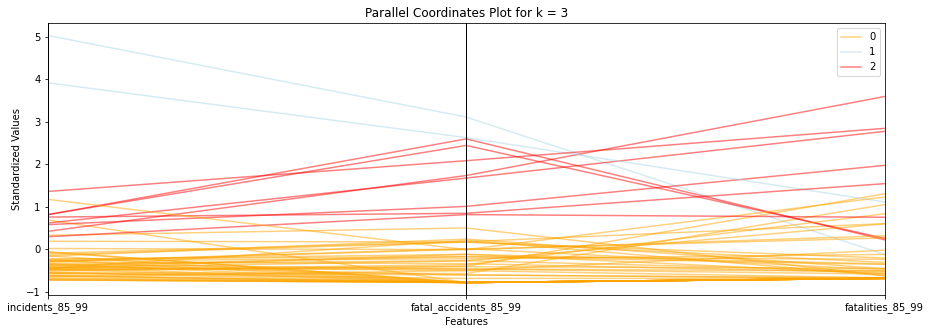

In [80]:
# Running K-means on the past data
k3_past = KMeans(n_clusters=3, random_state=5508, n_init=10)
k3_past.fit_predict(scaled_past.values)

# Parallel Coordinates Plot
past_features = scaled_past.columns
scaled_past['cluster'] = k3_past.labels_

plt.figure(figsize=(15, 5))
parallel_coordinates(scaled_past, 'cluster', color=['orange', 'lightblue', 'red'], alpha=0.5)
plt.title('Parallel Coordinates Plot for k = 3')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.grid()


In [81]:
# extract the cluster centers
past_cluster_centers = pd.DataFrame(k3_past.cluster_centers_, columns=past_features)
past_cluster_centers

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99
0,-0.318108,-0.412317,-0.325627
1,4.476179,2.870840,0.497462
2,0.710077,1.653115,1.747988


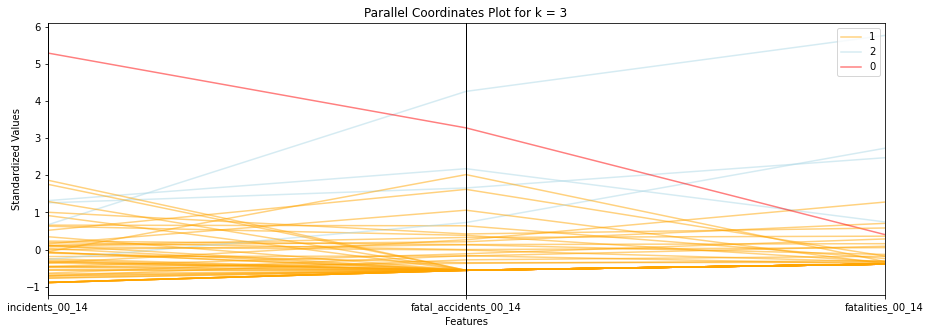

In [82]:
# Kmeans clustering on the present data
k3_present = KMeans(n_clusters=3, random_state=5508, n_init=10)
k3_present.fit_predict(scaled_present.values)

# Parallel Coordinates Plot
present_features = scaled_present.columns
scaled_present['cluster'] = k3_present.labels_

plt.figure(figsize=(15, 5))
parallel_coordinates(scaled_present, 'cluster', color=['orange', 'lightblue', 'red'], alpha=0.5)
plt.title('Parallel Coordinates Plot for k = 3')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.grid()

Based on the 2 parallel coordinates plots, we can see that the clustering using the past and present features are quite similar. The 2 models seem to be able to cluster the airlines that have a lower number of incidents, fatal accidents and fatalities across both in the past and present. Likewise, we are able to see that there are clusters that catches a higher number of incidents, moderate number of fatal accidents and low number of fatalities, and also clusters that have a low number of incidents, moderate number of fatal accidents and high number of fatalities.

We might be able to visualise this in a 3D space across similar variables, as well as looking at the number of instances put into each cluster for each model.

In [83]:
# extract the cluster centers
present_cluster_centers = pd.DataFrame(k3_present.cluster_centers_, columns=present_features)
present_cluster_centers

,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,5.288897,3.273877,0.405138
1,-0.161978,-0.237105,-0.237395
2,0.743001,2.204622,2.925504


We compare the results of these 2 models, and see if there are any differences in the clusters, or if the clusters changed. 

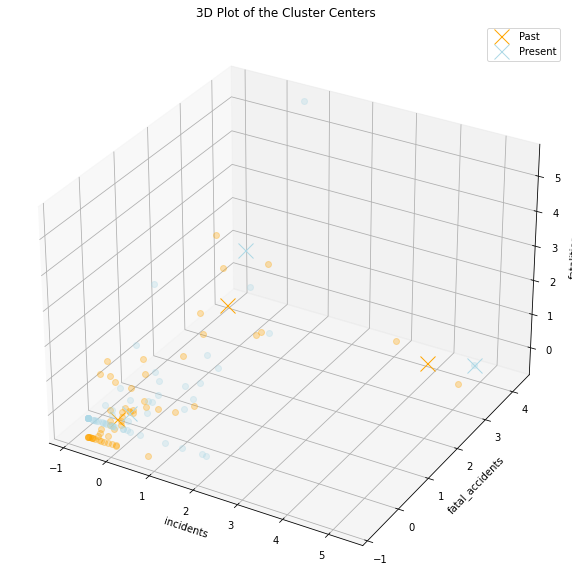

In [84]:
# 3d plot of the cluster centers
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')
ax.plot(past_cluster_centers['incidents_85_99'], past_cluster_centers['fatal_accidents_85_99'], past_cluster_centers['fatalities_85_99'], 'x', color='orange', label='Past', alpha=1, markersize=15)
ax.plot(scaled_past['incidents_85_99'], scaled_past['fatal_accidents_85_99'], scaled_past['fatalities_85_99'], 'o', color='orange', alpha=0.3)
ax.plot(scaled_present['incidents_00_14'], scaled_present['fatal_accidents_00_14'], scaled_present['fatalities_00_14'], 'o', color='lightblue', alpha=0.3)
ax.plot(present_cluster_centers['incidents_00_14'], present_cluster_centers['fatal_accidents_00_14'], present_cluster_centers['fatalities_00_14'], 'x', color='lightblue', label='Present',alpha=1, markersize=15)
ax.set_xlabel('incidents')
ax.set_ylabel('fatal_accidents')
ax.set_zlabel('fatalities')
plt.title('3D Plot of the Cluster Centers')
plt.legend()

In [85]:
# count the number of airlines in each cluster
(scaled_past['cluster'].value_counts(), scaled_present['cluster'].value_counts())

(0    46
 2     8
 1     2
 Name: cluster, dtype: int64,
 1    51
 2     4
 0     1
 Name: cluster, dtype: int64)

Comparing the cluster centers, and the number of instances that are in the 3 clusters for the past and present variables, we are able to infer that the clusters are quite similar. The clusters are able to capture the airlines that are generally safer, and the airlines that are generally less safe. The proportion of instances in each cluster however is slightly different, as seen above, where the number of instances in cluster 0 is higher in the past, and the number of instances in cluster 1 is higher in the present. This might indicate that the airlines are generally safer now as compared to the past.

Now, we want to identify which airlines are in cluster 2, where the fatalities are overall higher. 

In [86]:
scaled_past['airline'] = airline_name
scaled_present['airline'] = airline_name

scaled_past[scaled_past['cluster'] == 2]

,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,cluster,airline
13,0.424265,1.737298,3.596145,2,Avianca
16,0.619926,1.677337,2.776651,2,China Airlines
20,0.582631,1.011628,1.976327,2,Egyptair
24,0.760151,0.849063,1.546541,2,Garuda Indonesia
35,1.362514,2.086531,2.847340,2,Pakistan International
36,0.818608,2.445651,0.259975,2,Philippine Airlines
38,0.814972,2.598908,0.224727,2,Royal Air Maroc
53,0.297549,0.818500,0.756200,2,Vietnam Airlines


In [87]:
scaled_present[scaled_present['cluster'] == 2]

,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,cluster,airline
22,1.316236,2.176056,0.744872,2,Ethiopian Airlines
25,1.255979,1.658199,2.470600,2,Gulf Air
29,0.665130,4.256451,5.761024,2,Kenya Airways
34,-0.265338,0.727784,2.725522,2,Malaysia Airlines


The airlines that were generally more dangerous in the past are not the same ones that are dangerous in the present.

**5. Ratio of the present and past features**

We consider the ratio of the present and past features, and see if there are any differences in the clusters.

In [88]:
# Reconstructing the variables to be a ratio
airline_v_past.columns = airline_v_present.columns
airline_ratio = airline_v_present/(airline_v_past + 0.000001) # add noise if 0 to avoid division by 0
airline_ratio.columns = ['incidents', 'fatal', 'fatalities']
airline_ratio.head(5)


,incidents,fatal,fatalities
0,0.000000,0.000000,0.000000
1,0.004711,0.000825,0.066381
2,0.002552,0.000000,0.000000
3,0.008335,0.000000,0.000000
4,0.001071,0.000000,0.000000


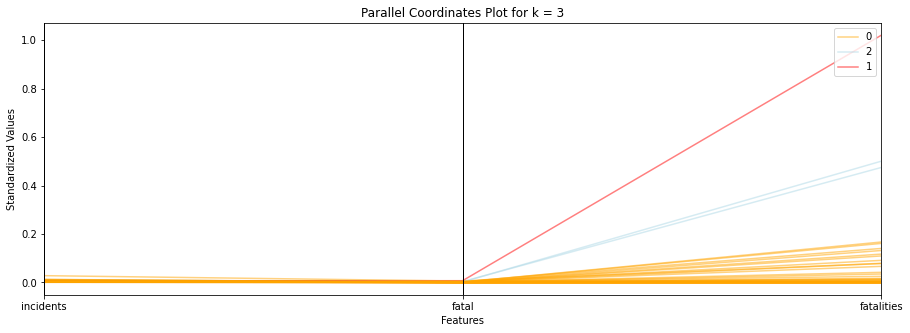

In [89]:
# Kmeans clustering on K=3
k3_ratio = KMeans(n_clusters=3, random_state=5508, n_init=10)
k3_ratio.fit_predict(airline_ratio.values)

# Parallel Coordinates Plot
ratio_features = airline_ratio.columns
airline_ratio['cluster'] = k3_ratio.labels_

plt.figure(figsize=(15, 5))
parallel_coordinates(airline_ratio, 'cluster', color=['orange', 'lightblue', 'red'], alpha=0.5)
plt.title('Parallel Coordinates Plot for k = 3')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.grid()

In [90]:
# Identify the cluster centers
ratio_cluster_centers = pd.DataFrame(k3_ratio.cluster_centers_, columns=ratio_features)
ratio_cluster_centers

,incidents,fatal,fatalities
0,0.003923,0.000643,0.024790
1,0.007158,0.007209,1.020133
2,0.006400,0.002620,0.487435


We observe now that by considering the 3 new features as the ratio of the variables, we are able to understand, from both the parallel coordinate plot, as well as looking at the cluster centers, an idea of how the clusters are formed. There is a very obvious pattern here, where the clusters clearly are distinct from each other in terms of fatalities. We can see that cluster 0 have a generally low ratio of value of fatalities, cluster 2 a moderate amount and cluster 1 the highest. As compared to the previous clustering methods that we have performed earlier, we are able to understand airline safety across the 2 seasons, as a ratio. Any value above 1, we can infer that the airline has decreased in safety and values below 1 would signal an improvement. 

An optimal airline safety ratio here would imply values towards 0 for all of the cases. We see in cluster 1, the ratio of fatalities is above 1, and for the incidents and fatal variables, the value there is also the highest among the clusters. We want to identify which airlines are in cluster 1.

In [91]:
# Cluster 1 Airlines
airline_ratio['Airline'] = airline_name

airline_ratio[airline_ratio['cluster'] == 1]

,incidents,fatal,fatalities,cluster,Airline
29,0.007158,0.007209,1.020133,1,Kenya Airways


In [92]:
airline_ratio[airline_ratio['cluster'] == 2]

,incidents,fatal,fatalities,cluster,Airline
25,0.009921,0.003318,0.474484,2,Gulf Air
34,0.002879,0.001923,0.500386,2,Malaysia Airlines


Kenya Airlines seems to be the unsafest airline to fly with, followed by the airlines in cluster 2, Gulf Air and Malaysia Airlines. Comparing this to task 2, we can see that the same airlines are clustered in cluster 2 overall as well. Overall, aviation have become more safe over the years. However, there some airlines that maybe have their safety measures left more to be desired.

# Part III: Linkage Based Clustering (Hierarchical Clustering)

In this section, we will explore a different method of clustering, hierarchical clustering. Unlike the K-means method that we have studied earlier, there are some limitations to the clustering algorithm. For example, choosing a pre-determined number of clusters beforehand, as well as the initial centroids (although the algorithm will always converge but might not be optimal if init points are arbitary). Additionally, K-means might also not perform well if the data is not sperical or if the data is sparse. 

Hierarchical clustering is an alternative approach to clustering that addresses some of the above issues. In this method, we do not need to specify the number of clusters beforehand. Instead, we build a hierarchy of clusters, also known as a dendrogram. We can then decide how many clusters we want by interpreting the dendrogram. At the end, we will then explore the use of a mixture of hierarchical clustering to find the initial centroids and K-means to optimize the clustering results. Additionally, we will also explore the use of dimensionality reduction techniques like PCA to reduce the dimensionality of the data and then perform clustering on the reduced data.

We will use the USArrests dataset which contains the statistics in arrests per 100000 residents for all 50 US states. The crime related features are Murder, Assault and Rape. UrbanPop represents the percentage of the population living in urban areas.

In [94]:
# Load in the dataset:
crimes = pd.read_csv('../datasets/USArrests.csv')

In [95]:
crimes.head(5)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Earlier, we recognised that the feature UrbanPop is a percentage of the population that were living in urban areas. Therefore, the 3 crime features are not on a similar measurement scale, therefore we might be required to scale the data later. However, we want to just use the raw data first.

**1. Hierarchical Clustering using Raw Data**

Using the raw data, we want to cluster the states using complete linkage and Euclidean distance, then cut the dendrogram at to give us 3 distinct clusters.

In [96]:
# Before applying the AgglomerativeClustering algorithm, we need to detach the state column from the dataset.

states = crimes.iloc[:,0]
crimes = crimes.drop('State', axis=1)

In [97]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Hierarchical clustering, complete linkage and euclidean distance:
model = AgglomerativeClustering(distance_threshold=120, n_clusters=None, affinity='euclidean', linkage='complete')
model.fit(crimes)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=120,
                        linkage='complete', n_clusters=None)

In [98]:
states = np.array(states)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

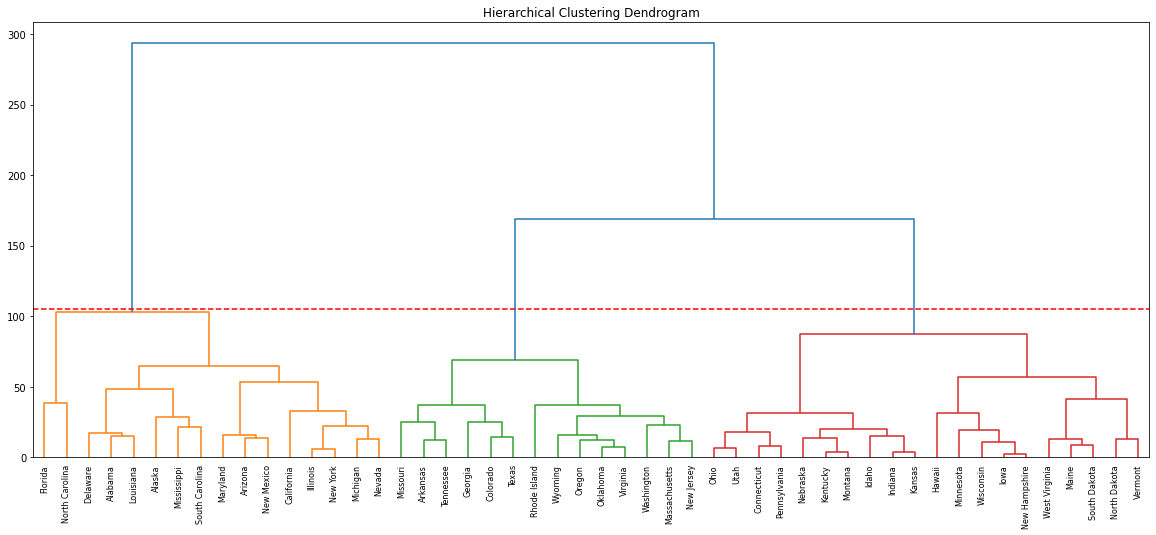

In [99]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, labels=states, truncate_mode='level', color_threshold=105)
plt.hlines(105, 0, 500, colors='r', linestyles='dashed')

Looking at the dendrogram, we can see that that around the distance threshold range of around 105-175, the hierarchical clustering algorithm results in 3 clusters, as shown in the orange, green and red clusters. The first pairwise observations to be clustered together first based on nearest distance seem to be Iowa and New Hampshire, followed by Kentucky and Montana. The algiorithm continues to find the next nearest clusters and merge them together until we have 3 distinct clusters. The distance threshold where the clusters are 3 is 102.86. 

In [100]:
# Attach the cluster labels 
crimes['cluster'] = model.labels_
crimes['states'] = states

In [101]:
crimes.head(5)

,Murder,Assault,UrbanPop,Rape,cluster,states
0,13.2,236,58,21.2,0,Alabama
1,10.0,263,48,44.5,0,Alaska
2,8.1,294,80,31.0,0,Arizona
3,8.8,190,50,19.5,2,Arkansas
4,9.0,276,91,40.6,0,California


In [102]:
# cluster centroids based on each feature on cluster
crimes.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,11.812500,272.562500,68.312500,28.375000
1,4.270000,87.550000,59.750000,14.390000
2,8.214286,173.285714,70.642857,22.842857


If we look at the cluster centroids for the clusters on the features, we can see that states that are in cluster 0 have a high crime rate, while states in cluster 1 have a low crime rate. States in cluster 2 have a moderate crime rate. We can further visualise this using the pairplot between the features below and observe that our analysis is indeed true. However, we tell from the assault density kernels that there is very good seperation between the 3 clusters, which might lead us to believe that the clustering algortihm does very well on identifying the clusters based on the assault. The UrbanPop feature seems to have little influence on determining which clusters the states belong to.

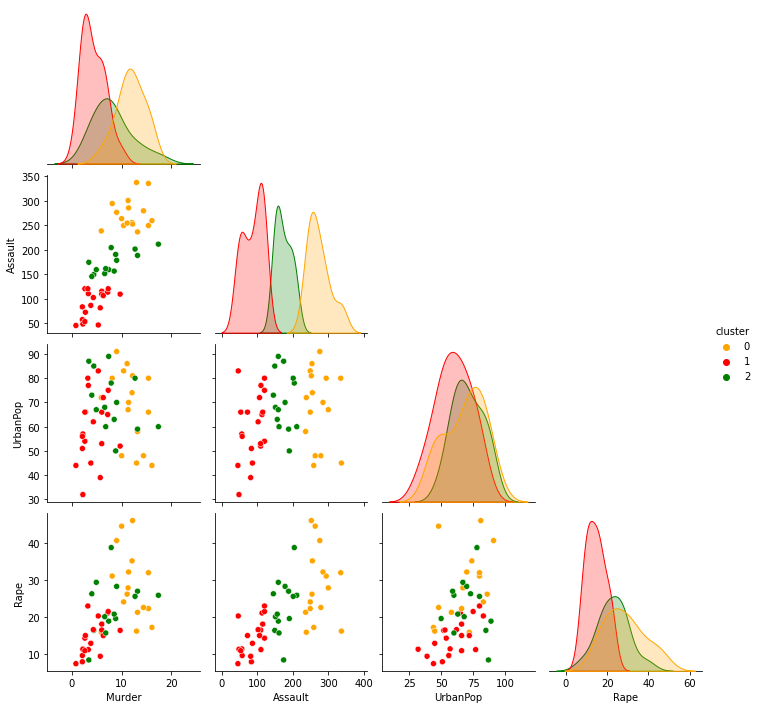

In [103]:
import seaborn as sns
sns.pairplot(crimes, hue='cluster', palette=['orange','red','green'], corner=True)

**2. Scaling the Data**

We specified earlier that because the crime features and UrbanPop are on different units of measurements, we might need to scale the data using StandardScaler. We then perform the same steps and then compare the results from earlier.

In [104]:
crimes = pd.read_csv('../datasets/USArrests.csv')
crimes = crimes.drop('State', axis=1)

In [105]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
crimes_scaled = pd.DataFrame(scaler.fit_transform(crimes), columns=crimes.columns)

In [106]:
# Hierarchical clustering, complete linkage and euclidean distance:
model = AgglomerativeClustering(distance_threshold=4.46494857, n_clusters=None, affinity='euclidean', linkage='complete')
model.fit(crimes_scaled)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=4.46494857,
                        linkage='complete', n_clusters=None)

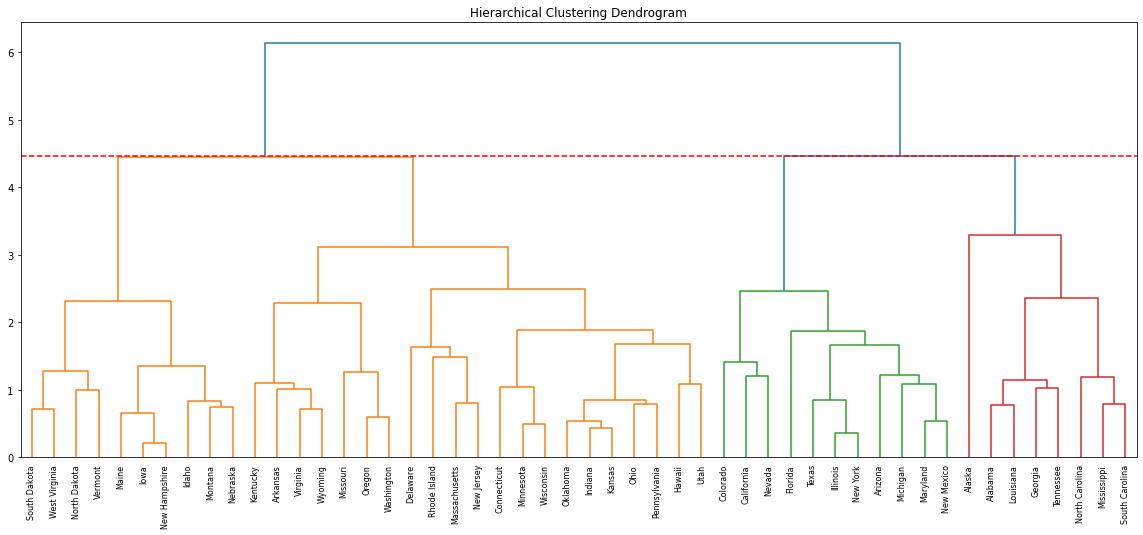

In [107]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, labels=states, truncate_mode='level', color_threshold=model.distances_[-2])
plt.hlines(model.distances_[-2], 0, 500, colors='r', linestyles='dashed')


Upon scaling the data, we can observe that the dendrogram is quite different as compared to the previous one with the unscaled data. Prior to scaling the dataset, we observed that the feature assault had significantly higher values than the other features, which can impact the clustering algorithm because it uses a distance metric. By scaling the data, we ensure that all the features are on the same scale and therefore, the clustering algorithm will not be biased towards the feature with the higher values.

We also want to look at the each cluster centroids of all the features to understand what the characteristics of each cluster are.

In [108]:
# Cluster Centroids
crimes_scaled['cluster'] = model.labels_
crimes_scaled['states'] = states

crimes_scaled.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
0,-0.645859,-0.657892,-0.118728,-0.527735
1,1.461013,0.993817,-0.840237,0.356494
2,0.757594,1.131283,0.945679,1.227985


Now if we look at the cluster centroids, we can start to have an appreciation as to how the clusters are determined. There is more of a trend, especially in the case of cluster 2, where there is a higher percentage of UrbanPop, there is a higher level of assault and rape cases. For states with a lower UrbanPop, for cluster 1, it shows that the murder cases are high this those states. Cluster 0 shows states that have low crime rates. Therefore, we can perhaps start to understand that states that have a higher population percentage living in urban areas have higher crime rates of assault and rape, while states with a lower urban population tend to have quite high homocide rates.

Likewise, we want to plot a pairwise plot to cement our understanding.

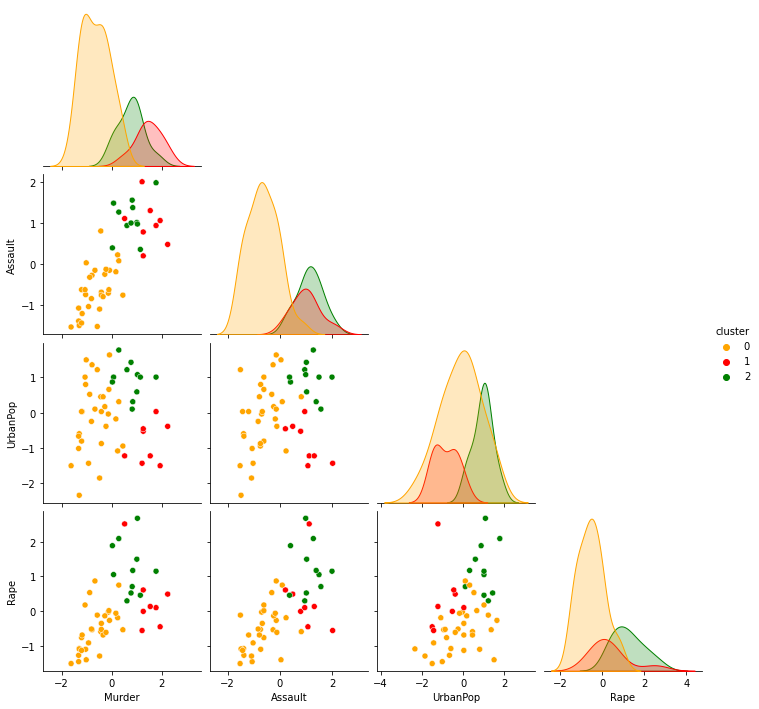

In [109]:
# Pairplot
sns.pairplot(crimes_scaled, hue='cluster', palette=['orange','red','green'], corner=True)

We observe that indeed states that are in cluster 0 have lower overall crime rates, as compared to the other 2 clusters. The decision to scale the data makes sense as this approach allows us to see the relationship between the Urbanpop variable and the crime featurs, so we choose to scale the data. If we look at the states in cluster 2, we can see that for those states, they are mainly the bigger and more populous states where they are more metropolitan areas like New York and California. Considering the recent events that have been occuring in the U.S, we can perhaps say that this clustering model does well in terms of identifying similar states, based on crime and urban population.

**3. PCA and Clustering**

In this section, we choose to do dimensionality reduction using PCA and then perform clustering on the reduced data. We will use the scaled data from the previous section. This will allow us to visualise the data in a 2D space to give us better understanding on how the clustering algorithm performs. We define the number of components to be 2, so that we can visualise the data in a 2D space. By choosing the number of components to be 2, we are able to explain about the 86.7% of the variance in the data, where the first PC explains 62% of the variance and the second PC explains 24.7% of the variance. 

In [110]:
# Take off the previous cluster column and state column
crimes_scaled = crimes_scaled.drop(['cluster', 'states'], axis=1)

In [111]:
# PCA on scaled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(crimes_scaled)
pca_scores = pd.DataFrame(pca.fit_transform(crimes_scaled), columns=['PC1', 'PC2'])
pca.explained_variance_ratio_

array([0.62006039, 0.24744129])

In [112]:
# Hierarchical clustering, complete linkage and euclidean distance on PC1 and PC2:
# model_PCA.distances_[-2] # get the distance threshold where it splits into 3 clusters, then apply back into the model
model_PCA = AgglomerativeClustering(distance_threshold=4.222683431452698, n_clusters=None, affinity='euclidean', linkage='complete')
model_PCA.fit(pca_scores)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean',
                        distance_threshold=4.222683431452698,
                        linkage='complete', n_clusters=None)

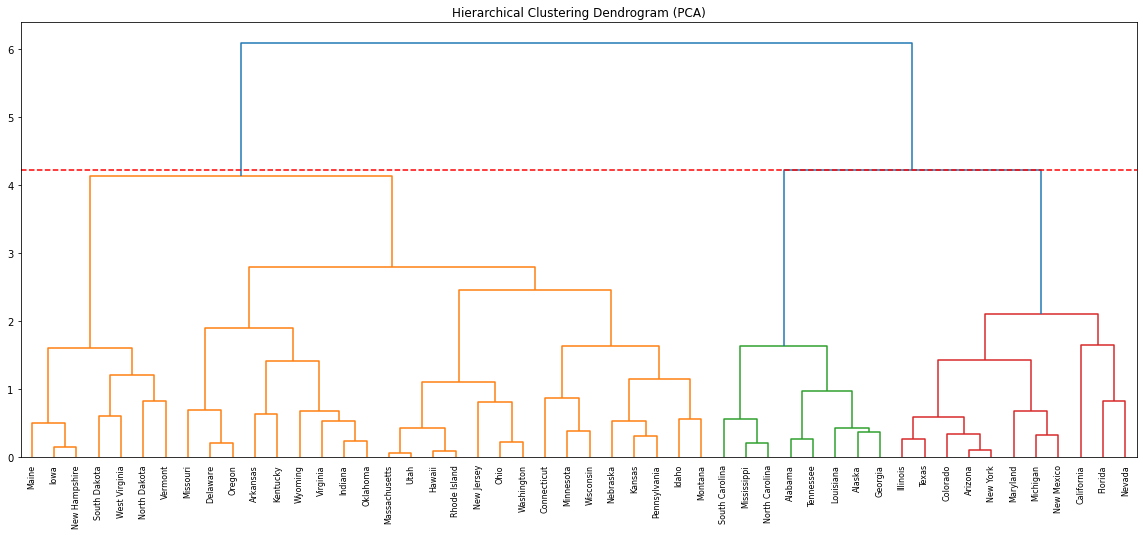

In [113]:
# Plot the dendrogram
plt.figure(figsize=(20, 8))
plt.title("Hierarchical Clustering Dendrogram (PCA)")
plot_dendrogram(model_PCA, labels=states, truncate_mode='level', color_threshold=model_PCA.distances_[-2])
plt.hlines(model_PCA.distances_[-2], 0, 500, colors='r', linestyles='dashed')

From the dendrogram, we can see that the hierarchical clustering algorithm results in 3 clusters, as shown in the orange, green and red clusters. The hierarchical clustering algorithm on the PCA scores of PC1 and PC2 are very similar to the hierarchical clustering done in Task 2. 

<Figure size 720x576 with 0 Axes>

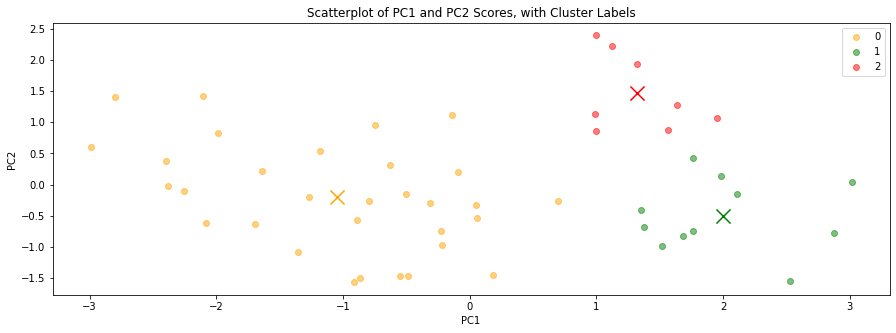

In [114]:
# Plot the scatterplot
pca_scores['cluster'] = model_PCA.labels_
pca_scores['states'] = states
plt.figure(figsize=(10, 8))
color_map = {0: 'orange', 1: 'green', 2:'red'}
plt.figure(figsize=(15, 5))

for type in [0,1,2]:
    is_cluster = pca_scores['cluster']  == type
    plt.scatter(pca_scores.loc[is_cluster, 'PC1'], pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    plt.scatter(pca_scores.loc[is_cluster, 'PC1'].mean(), pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=200)


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of PC1 and PC2 Scores, with Cluster Labels')
plt.legend()  # Automatically uses labels specified in plt.scatter
plt.show()

In [115]:
# Get loadings of PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
loadings

,PC1,PC2
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


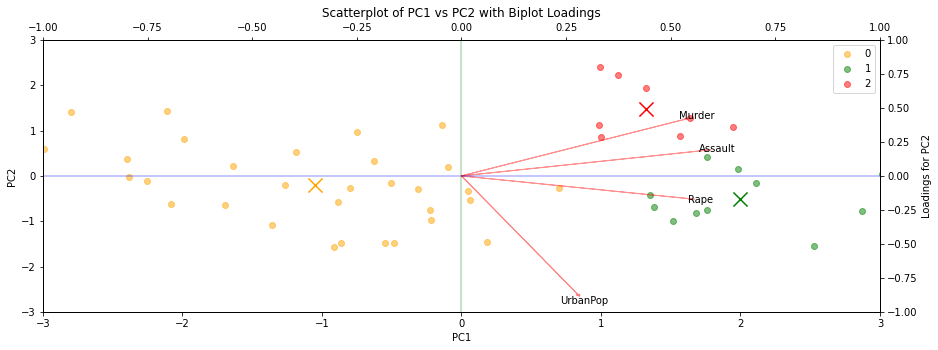

In [116]:
# Scatterplot of PC1 vs PC2 with biplot
fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in [0,1,2]:
    is_cluster = pca_scores['cluster']  == type
    ax1.scatter(pca_scores.loc[is_cluster, 'PC1'], pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    ax1.scatter(pca_scores.loc[is_cluster, 'PC1'].mean(), pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=200)
    
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings')
ax1.legend()
plt.show()

From the plot above, we can see that similarly to the cluster centers in Task 2, we can see that states in cluster 0 have low crime rates. For cluster 1, we can see that rape cases tend to be higher in higher urban population states. For cluster 2, we can see that murder rates are the highest, where there is lower urban population. Comparing this to the group characteristics in Task 2, we can conclude that both the PCA and scaled hierarchical clustering yield similar results, group characteristics and interpretation.

**4. K-Means Clustering using Group Means**

In this section, we make use of the group means that we have found above in the hierarchical clustering that we have done on the PC scores, as the intital centroids for the K-means clustering. Seeing that we have 3 clusters, we will use K=3 as the number of predetermined clusters prior to running the algorithm. We then analyse the results to see how the K-means compares to the Hierarchical clustering algorithm.

In [117]:
# Get the cluster centroids
init_centroids = pca_scores.groupby('cluster').mean()
k_pca_scores = pca_scores.drop(['cluster', 'states'], axis=1)

In [118]:
from sklearn.cluster import KMeans

# K-Mean clustering on PC1 and PC2
kmeans = KMeans(n_clusters=3, init=init_centroids, n_init=1, random_state=5508)
kmeans.fit_predict(k_pca_scores)

array([2, 2, 1, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [119]:
# Attach the states and labels to the PC1 and PC2 scores
k_pca_scores['cluster'] = kmeans.labels_
k_pca_scores['states'] = states

In [120]:
# See which state is different in both clustering methods
pca_scores['kmeans_cluster'] = kmeans.labels_
diff = pca_scores[pca_scores['kmeans_cluster'] != pca_scores['cluster']]
diff

,PC1,PC2,cluster,states,kmeans_cluster
3,-0.141420,1.119797,0,Arkansas,2
24,0.696787,-0.263355,0,Missouri,1


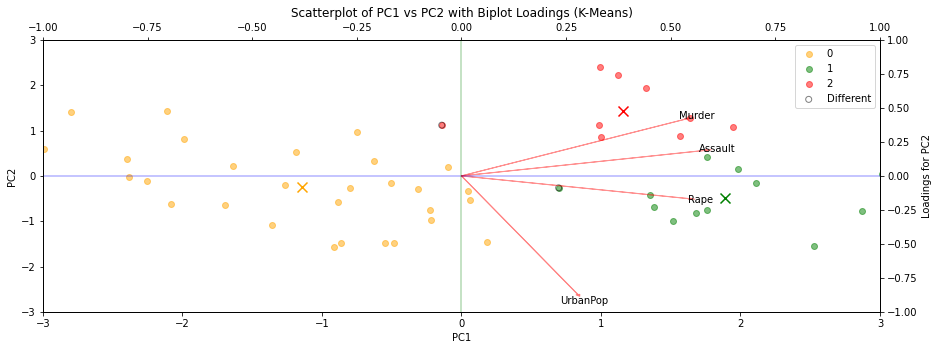

In [121]:
# Scatterplot of PC1 vs PC2 with biplot
fig, ax1 = plt.subplots(1,1)
twin_stacked = ax1.twiny().twinx()

for type in [0,1,2]:
    is_cluster = k_pca_scores['cluster']  == type
    ax1.scatter(k_pca_scores.loc[is_cluster, 'PC1'], k_pca_scores.loc[is_cluster, 'PC2'], 
                color=color_map[type], alpha=0.5, label=type)
    ax1.scatter(k_pca_scores.loc[is_cluster, 'PC1'].mean(), k_pca_scores.loc[is_cluster, 'PC2'].mean(), marker='x', alpha=1, color=color_map[type], s=100)
    
ax1.scatter(diff['PC1'], diff['PC2'], edgecolors='black', marker='o', alpha=0.5, color='none', label='Different')

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=crimes_scaled.columns)
labels = loadings.index

# plot the biplot
for i in range(loadings.shape[0]):
    twin_stacked.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.01, color='r', alpha=0.4)
    twin_stacked.text(loadings.iloc[i, 0]*1.05, loadings.iloc[i, 1]*1.05, labels[i], color='black', ha='center', va='center', fontsize=10)
# add x axes for loadings
twin_stacked.axhline(0, color='blue', alpha=0.3)
twin_stacked.axvline(0, color='green', alpha=0.3)

ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)
twin_stacked.set_xlim(-1, 1)
twin_stacked.set_ylim(-1, 1)
twin_stacked.figure.set_size_inches(15, 5)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
twin_stacked.set_xlabel('Loadings for PC1')
twin_stacked.set_ylabel('Loadings for PC2')
ax1.set_title('Scatterplot of PC1 vs PC2 with Biplot Loadings (K-Means)')
ax1.legend()
plt.show()

If we compare the scatterplot from the K-means clustering to the plot using the Hierarchical Clustering method, we can see that the clustering is somewhat similar except for 2 instances. From the instances that we different, we can see that the state of Arkansas was clustered under cluster 2, and the state of Missouri in cluster 1 in the K-means clustering, where in the hierarchical clustering they were clustered under 0. 

By comparing the 2 scatterplots to determine which clustering algorithm produces a more accurate result, we perhaps conclude that the hierarchical clustering is slightly better, as the misclassified points visually look closer to cluster 0, than to their respective clusters in the K-means clustering.